In [9]:
%matplotlib inline
from tqdm import tqdm
import pandas as pd
import numpy as np
import pymc3 as pm
from theano import shared
import theano.tensor as tt
import theano
from pymc3.distributions.transforms import t_stick_breaking

In [10]:
import pickle
with open('data/gch-100-100-0.25-5.00.pkl', 'rb') as f:
  GCH = pickle.load(f)
S = 100
npdata = np.array(GCH, dtype = int)
V = len(GCH)
V, type(V)

(16, int)

In [11]:
def get_vmask():
    v_mask = np.zeros([S,S,S])
    for s in np.arange(S):
        for q in np.arange(s,S):
            c1 = np.zeros(s)
            c2 = np.ones(q-s)
            c3 = np.zeros(S-q)
            v_mask[s,q]= np.concatenate((c1, c2, c3))
    return tt.constant(v_mask)

In [12]:
def get_imask():
    s_mask = np.zeros([V,S])
    q_mask = np.zeros([V,S])
    for w in np.arange(V):
        f, l = npdata[w, 0] , npdata[w, 1]
        s_mask[w] = np.concatenate((np.ones(f+1), np.zeros(S - f -1)))
        q_mask[w] = np.concatenate((np.zeros(l), np.ones(S-l)))
    i_mask = np.einsum("is,iq->isq", s_mask, q_mask)
    return tt.constant(i_mask)

In [13]:
def get_Risq(a,b):
    tmp_u = npdata[:, 2]
    expanded_u = tmp_u[:, np.newaxis, np.newaxis] *  np.ones((V, S, S)) # V x S x S
    d = np.broadcast_to(np.triu(np.ones([S,S]), 0).cumsum(axis =1), (V, S, S)) # V x S x S
    n = tt.constant(np.clip(d,a_min=0,a_max=S+1))
    n_u = np.triu(d - expanded_u, 0)
    n_u = tt.constant(np.clip(n_u,a_min=0,a_max=max(tmp_u))) # V x S x S
   
    
    # The beta binomial
    R_isq =   tt.gammaln(n+1)
    R_isq -=  tt.gammaln(expanded_u+1)
    R_isq -=  tt.gammaln(n_u+1)   
    R_isq +=  tt.gammaln(expanded_u+a)
    R_isq +=  tt.gammaln(n_u+b)
    R_isq -=  tt.gammaln(n+a+b)
    R_isq +=  tt.gammaln(a+b) - tt.gammaln(a) - tt.gammaln(b)

    # The above is the computation of the log, so we take the exponent
    return tt.exp(R_isq)

In [14]:
def get_Risq0(a,b):
    # n = q - s + 1
    n = tt.constant(np.triu(np.ones([S,S]), 0).cumsum(axis =1))
    R0_sq = tt.gammaln(n + b) - tt.gammaln(n + a + b) + tt.gammaln(a + b) - tt.gammaln(b)
    return tt.exp(R0_sq)

In [15]:
def logp_capture(arr, phi, a, b, U, phi_mask, i_mask, R_isq, R0_sq):
    def ll_capture_f(mycaptures):
        
        # Likelihood of Capture Li
        phi_v = tt.pow(1-phi, phi_mask)
        phi_v = tt.prod(phi_v, axis=2)
        LD = arr[:, np.newaxis] * phi_v * phi
        LD_isq = tt.mul(LD, i_mask)
        Li = tt.batched_tensordot(LD_isq, R_isq, axes = 2)
        
        # Likelihood of No-Capture L0
        v0_mask = 1 - phi_mask[0] # tihs is reuse
        LD0 = tt.mul(LD, v0_mask)
        L0 = tt.sum(LD0 * R0_sq)
        
        # Multinomial
        obj1 = tt.gammaln(tt.constant(V)+U+1.0) - tt.gammaln(U+1.0) - tt.gammaln(tt.constant(V)+ 1.0) #
        obj2 = tt.sum(tt.log(Li))
        obj3 = U * tt.log(L0)

        objective = obj1 + obj2 + obj3 
        
        return objective
    
    return ll_capture_f

In [18]:
# custom log-liklihood
# model
with pm.Model() as model:
    # parameters
    U = pm.DiscreteUniform('Unseen', lower=V, upper=5*S)
    a = pm.Uniform('alpha', 0., 1.)
    b = pm.Uniform('beta', 2, 10)
    phi    = pm.Uniform('departure', 0., 1., shape=S)
    arr    = pm.Dirichlet('arrival', a=np.array([1./S]*S), shape=S)
    
    # Masks: try to compute these once.
    phi_mask = get_vmask()  # S x S x S . all possible arrivals and departures for the "SURVIVAL"
    i_mask   = get_imask()  # KxK   . matrix with real possible arrival and departures
    R_isq = get_Risq(a, b) 
    R0_sq = get_Risq0(a, b)
    
    # Model Log-likelihood
    ob = pm.DensityDist('x', logp_capture(arr, phi, a, b, U, phi_mask, i_mask, R_isq, R0_sq), observed=npdata)

In [19]:
with model:
  #posterior = pm.sample(3, tune=0, chains=1, progressbar=False)
  #step = pm.NUTS()
  #posterior = pm.sample(100000, step=step, njobs = 4)
  posterior = pm.sample(1000, cores = 1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [Unseen]
>NUTS: [arrival, departure, beta, alpha]
100%|██████████| 1500/1500 [19:31<00:00,  1.28it/s]
There were 968 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8947824107255188, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2410 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8799101101746634, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


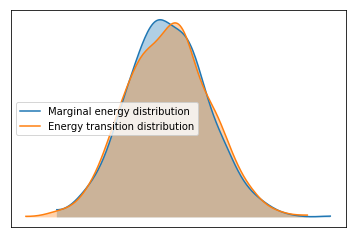

In [20]:
pm.energyplot(posterior);

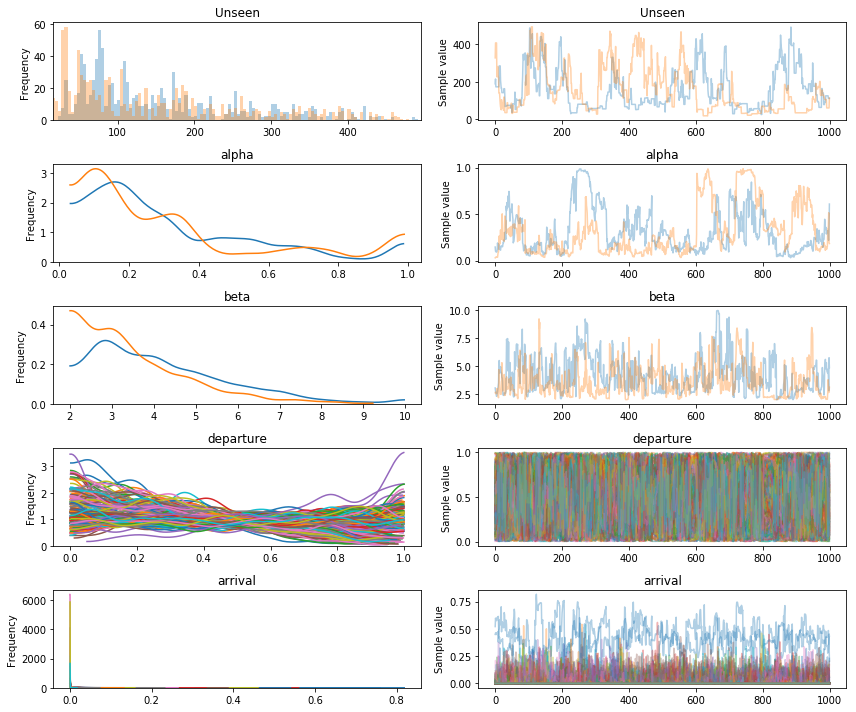

In [21]:
pm.traceplot(posterior);

In [22]:
pm.summary(posterior).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Unseen,156.85,112.11,9.93,17.00,391.00,36.83,1.00
alpha,0.32,0.25,0.02,0.03,0.91,28.83,1.00
beta,3.91,1.52,0.10,2.01,6.96,57.07,1.05
departure__0,0.24,0.19,0.01,0.00,0.59,190.13,1.00
departure__1,0.32,0.22,0.01,0.00,0.74,219.76,1.01
departure__2,0.27,0.20,0.01,0.00,0.64,264.18,1.00
departure__3,0.43,0.24,0.01,0.00,0.87,199.91,1.00
departure__4,0.67,0.27,0.02,0.13,1.00,201.68,1.01
departure__5,0.54,0.29,0.02,0.09,1.00,175.78,1.00
departure__6,0.47,0.28,0.02,0.00,0.91,192.71,1.01
